# Demonstration des Huygenschen Prinzips

Am Beispiel von Punktquellen die sich zu einer Welle in 2 Dimensionen überlagern.

Es wird die Wellengleichung auf einem Gitter gelöst. 
Das Programm besteht aus zwei Teilen, zuerst der Wellenlöser der als Klasse aufgeführt ist und dann das eigentliche Programm, das die Quellen verteilt und die Lösung zu bestimmten Zeitpunkten plottet.

In [3]:
import numpy as np
import time


class WaveSolverIn(object):
    
    """
    WaveSolver       Class calculates the wave equation in a homogeneous medium
    with a prefectly matched layer
    nx:              size of square calculation grid
    wavelength:      wavelength of the wave
    CFL:             CFL parameter dt*c/dx should be smaller than 1/sqrt(2)
    sim_duration:    duration of simulation

    plotcallback:    callback function for plotting/saving the result
                     the callback receives two parameters self.u and time
    output:          number of outputs per period of the source
    slowdown:        sleep slowdown secondes between after the calculations of output
    rho1, c1:        density and speed of sound of background phase
    rho2, c2:        density and speed of sound of scatterers
    src_cycles:      duration of the src in cycles (1/frequency)
    
    Following the numerical scheme derived in http://arxiv.org/pdf/1001.0319v1.pdf
    Marcus J. Grote and Imbo Sim for the PML, accounts for inhomogeneous medium (rho & c)
    """
    
    def __init__(self, nx=128, wavelength=.3, CFL=0.1,\
                 sim_duration=2., output=5, slowdown=0, plotcallback=None,\
                 rho1=1., c1=1., rho2=1., c2=1., src_cycles=1):
        
        
        self.__nx = nx
        self.__ny = self.__nx
        self.__size = 2.
        self.__dx = self.__size/(self.__nx-1)
        self.__c1 = c1
        self.__rho1 = rho1
        self.__c2 = c2
        self.__rho2 = rho2
        self.__sim_duration = sim_duration
        self.__slowdown = slowdown
        self.wavelength = wavelength
        self.__u  = np.zeros((self.__nx,self.__ny)) #amplitude at t
        self.__un = np.zeros((self.__nx,self.__ny)) #amplitude at t-dt
        self.__unn = np.zeros((self.__nx,self.__ny)) #amplitude at t-2*dt
        self.__rho = np.ones((self.__nx,self.__ny))*self.__rho1
        self.__cc = np.ones((self.__nx,self.__ny))*self.__c1*self.__c1
        self.CFL = CFL
        
        self.output = output 
        self.__n = 0
        self.__src_function = None
        if src_cycles is 1:
            self.__src_timefunction = self.__gausspulse
            self.__src_duration = (1./self.__nu+self.__src_t0)*1.1
        else:
            self.__src_timefunction = self.__sinetrain
            self.__src_tmax=src_cycles/self.__nu+self.__src_t0           
            self.__src_duration = (self.__src_t0+src_cycles/self.__nu+1./self.__nu*0.1)
       
        if plotcallback is not None:
            self.__plotcallback = plotcallback
        else:
            self.__plotcallback = self.simplecallback

        self.__absorber_y = []
    

    def simplecallback(self,u,t):
        """Prints the current time"""
        print("time {0:.2}".format(t))
    
    def cfg_simple(self):
        #Source
        self.__src_posx = 0
        self.__src_emissionlength = int(.95*(self.__nx))
        self.__src_starty = int(self.__nx/2.-self.__src_emissionlength/2.)
        self.__src_function = self.__planesource
        #Timestepper
        self.__timestepper = self.__inhomogeneous_stable

    def cfg_simplediffraction(self, disks=None, rects=None):

        self.__emissionlength=self.__nx
        self.__src_emissionlength = self.__nx
        self.__src_starty = int(self.__nx/2.-self.__src_emissionlength/2.)
        self.__src_posx = 0
        self.__src_function = self.__planesource
        yy, xx = np.meshgrid(np.linspace(0., self.__nx, self.__nx),
                             np.linspace(0., self.__ny, self.__ny))
        #Discs
        if disks is not None:
            #change impedance
            for i in range(disks.size):
                a=np.where((xx-disks['xpos'][i])**2.+
                              (yy-disks['ypos'][i])**2.<(disks['radius'][i]**2.))
                self.__cc[a]=self.__c2*self.__c2
                self.__rho[a]=self.__rho2
        #Rectangles
        if rects is not None:
            for i in range(rects.size):
                a=np.where((xx>=rects['x_up'][i]) & (xx<=rects['x_up']+rects['width'][i]) 
                           & (yy<=rects['y_up'][i]) & (yy>=rects['y_up'][i]-rects['height'][i]))
                self.__cc[a]=self.__c2*self.__c2
                self.__rho[a]=self.__rho2     
        #update CFL
        self.CFL=self.CFL          
        #Timestepper
        self.__timestepper = self.__inhomogeneous_stable
        
    def cfg_singleslit(self, ow=0.1, pos=0.3):
        """
        Single slit experiment, where slit is oriented along y-axis,
        and the wave is coming from the left. The homogeneous wave
        equation is solved.
        ow:  width of the slit
        pos: x-position in real coordinates [0;size]
        """
        #Source
        self.__src_posx = 0
        self.__src_emissionlength = int(.9*self.__nx)
        self.__src_starty = int(self.__nx/2.-self.__src_emissionlength/2.)
        self.__src_function = self.__planesource
        #Absorber
        yy=np.linspace(0., self.__size, self.__ny)
        self.__absorber_y = np.asarray(np.where((yy>self.__size/2.+ow/2.)|\
                          (yy<self.__size/2.-ow/2.))[0])
        self.__absorber_x = int(pos/self.__size*self.__nx)
        #Timestepper
        self.__timestepper = self.__inhomogeneous_stable      
             
    def cfg_doubleslit(self, ow=0.1, dw=1., pos=0.3):
        """
        Double slit experiment, where the slits are oriented along y-axis,
        and the wave is coming from the left. The homogeneous wave
        equation is solved.
        ow:  width of the slits
        dw: distance between the slits' centers 
        pos: x-position between [0;size]
        """
        #Source
        self.__src_posx = 0
        self.__src_emissionlength = int(.9*(self.__nx))
        self.__src_starty = int(self.__nx/2.-self.__src_emissionlength/2.)
        self.__src_function = self.__planesource
        #Absorber
        yy = np.linspace(0., self.__size, self.__ny)
        self.__absorber_y = np.asarray(np.where((yy>self.__size/2.+dw/2.+ow/2.)|\
            (yy<self.__size/2.-dw/2.-ow/2.)|(yy>self.__size/2.-dw/2.+ow/2.) &\
            (yy<1.+dw/2.-ow/2.))[0])
        self.__absorber_x = int(pos/self.__size*self.__nx)
        #Timestepper
        self.__timestepper = self.__inhomogeneous_stable

    def cfg_pointsources(self, points):
        #Source
        self.__src_posxa = np.asarray(list(map(int,points['xpos']/self.__size*\
                                          (self.__nx))))
        self.__src_posya = np.asarray(list(map(int,points['ypos']/self.__size*
                                          (self.__ny))))
        self.__src_ampla = np.asarray(points['ampl'])    
        self.__src_function = self.__pointsource
        #Timestepper
        self.__timestepper = self.__inhomogeneous_stable
    
    def __pointsource(self, t):
        if t<self.__src_duration:
            self.__un[self.__src_posxa, self.__src_posya]=\
                self.__src_ampla*self.__src_timefunction(t)
                 
    def __planesource(self, t):
        if t<self.__src_duration:
            self.__un[self.__src_posx, self.__src_starty:self.__src_starty+self.__src_emissionlength]=\
                self.__src_timefunction(t)

    def __gausspulse(self, t):
        bw= 1.4
        bwr=-6
        ref = 10.0**(bwr / 20.0)
        a = -(np.pi * self.__nu * bw) ** 2 / (4.0 * np.log(ref))
        return -np.exp(-a *(t-self.__src_t0)**2.)*np.sin(2.*np.pi*self.__nu*(t-self.__src_t0))

    def __sinetrain(self, t):
        slp=10.*self.__nu #how fast the pulse rises
        return -np.cos(2.*np.pi*self.__nu*(t-self.__src_t0))/4.\
               *(1-np.tanh((t-self.__src_tmax)*slp))*(1.+np.tanh((t-self.__src_t0)*slp))


    @property
    def u(self):
        """Wave on the grid"""
        return self.__u
    
    @property
    def CFL(self):
        """CFL parameter (see class decription)"""
        return self.__CFL
    
    @property
    def dt(self):
        """Length of each timestep"""
        return self.__dt

    @property
    def nx(self):
        """X-size of the computational domain """
        return self.__nx
 
    @property
    def ny(self):
        """Y-size of the computational domain """
        return self.__ny
    
    @property
    def nu(self):
        """Frequency"""
        return self.__nu
    
    @property
    def omega(self):
        """Angular frequency"""
        return 2.*self.__nu*np.pi
    
    @property
    def nt(self):
        """Number of timesteps"""
        return int(self.__sim_duration/self.__dt)
    
    @property
    def wavelength(self):
        """Wavelength"""
        return self.__wavelength

    @property
    def c1(self):
        """Background speed of sound"""
        return self.__c1
    
    @property
    def nu(self):
        """Frequency"""
        return self.__nu
    
    @property
    def output(self):
        """List of output timesteps using the plotcallback function"""
        return self.__output
    
    @output.setter
    def output(self, output):
        self.__output=int(1./self.nu/self.__dt/output)
            
    @CFL.setter
    def CFL(self, CFL):
        self.__CFL = CFL  #CFL number < 1/sqrt(2)
        self.__dt = CFL*self.__dx/self.__cc.max()**.5
        self.__nt = int(self.__sim_duration/self.__dt)
    
    @wavelength.setter
    def wavelength(self, wavelength):
        self.__wavelength = wavelength
        self.__nu=self.__c1/self.__wavelength
        self.__src_t0=1./self.__nu
          
    def __inhomogeneous_stable(self):
        rho = self.__rho
        un = self.__un
        unn = self.__unn
        cc = self.__cc
        dx = self.__dx
        dt = self.__dt
        cconst = dt*dt/dx/dx
        self.__u[1:-1,1:-1] = 2.*un[1:-1,1:-1]-unn[1:-1,1:-1]+cconst*(cc[1:-1,1:-1]*\
        (un[:-2,1:-1]+un[2:,1:-1]+un[1:-1,:-2]+un[1:-1,2:]-4.*un[1:-1,1:-1])-\
        .25*rho[1:-1,1:-1]*((rho[2:,1:-1]-rho[:-2,1:-1])*(un[2:,1:-1]-un[:-2,1:-1])+\
        (rho[1:-1,2:]-rho[1:-1,:-2])*(un[1:-1,2:]-un[1:-1,:-2])))
        
        
    def __timestep(self):
        
            #Call Source     
            if self.__src_function:
                self.__src_function(self.__n*self.__dt)
            
            #One time step        
            self.__timestepper()
            
            #Impose reflective b.c. at boundary                 
            self.__u[0,:] = self.__u[1,:]
            self.__u[-1,:] = self.__u[-2,:]
            self.__u[:,0] = self.__u[:,1]
            self.__u[:,-1] = self.__u[:,-2]

            #Consider an absorber using plane wave radiation b.c.
            if np.size(self.__absorber_y)>0:
                self.__u[self.__absorber_x,self.__absorber_y] = -self.__dx/self.__dt/\
                    self.__c1*\
                    (self.__u[self.__absorber_x-1,self.__absorber_y]-\
                     self.__un[self.__absorber_x-1,self.__absorber_y])+\
                     self.__u[self.__absorber_x-1,self.__absorber_y]
                self.__u[self.__absorber_x+1,self.__absorber_y] = 0.                

            #save values for the time derivative 
            self.__unn = self.__un.copy() #n-1 time step
            self.__un = self.__u.copy()   #n time step


    def solvestep(self):
        """
        Solves the wave PDE for the time given set by output parameter.
        Function return False as long as t < than sim_duration
        """
        if self.__n>=self.__nt:
            return True
        
        for self.__n in range (self.__n,self.__n+self.__output):
            self.__timestep()

        self.__plotcallback(self.__u, self.__n*self.__dt)
        time.sleep(self.__slowdown)
        
        return False
    
    

FloatSlider(value=0.1, description='Wavelength', max=0.3, min=0.05, step=0.01)

IntSlider(value=5, description='No Sources', max=20, min=1)

Button(description='Start Simulation', style=ButtonStyle())

Output()

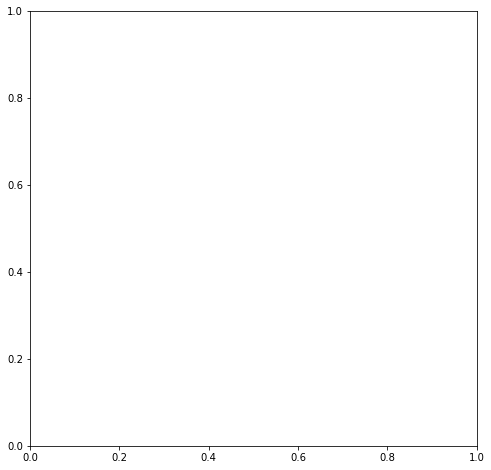

In [4]:
%matplotlib inline
from IPython import display #for continous display
import matplotlib.pyplot as plt #plotting
from ipywidgets import widgets #for the widgets
from ipywidgets import Output 

def plotwave(u,time):
    ax.clear()
    ax.imshow(np.flipud(np.transpose(u)), origin='upper', extent=[0., 2., 0., 2.],
               vmax=2, vmin=-2) #plot the wave field
    ax.text(0.1,1.8,"time {0:.5f}".format(time),fontsize=15,color='w') #annotate the time
    ax.set_xlim([0.,2.])
    ax.set_ylim([0.,2.])
    with out:
        display.clear_output(wait=True)
        display.display(ax.figure)
    
def linesource(a,n_p=5):

    p = np.zeros(n_p, dtype={'names':['ampl', 'xpos', 'ypos'],
                                 'formats':['f8','f8','f8']})
    #horizontal line
    n=0
    if n_p>1:
        dnx=2.*.5/(n_p-1)
        for i in range(n_p):
            p['ampl'][n] = 5.
            p['xpos'][n] = 1.
            p['ypos'][n] = 2.*.5/2.+dnx*i
            n += 1
    else:
        p['ampl'][n] = 5.
        p['xpos'][n] = 1.
        p['ypos'][n] = 1.    
    a.cfg_pointsources(p)
    return a

def halfcircle(a, n_p=5):

    p = np.zeros(n_p, dtype={'names':['ampl', 'xpos', 'ypos'],
                                 'formats':['f8','f8','f8']})
    n=0
    for i in range(n_p):
        p['ampl'][n] = 5.
        p['xpos'][n] = .5*np.cos(np.pi/(n_p-1)*i)+1.
        p['ypos'][n] = .5*np.sin(np.pi/(n_p-1)*i)+1.
        n += 1
    a.cfg_pointsources(p)
    return a

def fresnelplate(a):
    #Fresnel zone plate
    nn=33 #order of plate
    f=1. #focus position
    l=a.c1/a.nu #wavelength
    yy=np.linspace(0.,2.,a.ny)
    ampl=np.zeros(a.ny)
    n=0
    #make a zoneplate
    for i in range(0,nn,2):
        k=np.where(((yy-1.)<(((i+1)*l*(f+(i+1)*l/4.))**.5)) &
                   ((yy-1.)>((i*l*(f+i*l/4.))**.5)))
        ampl[k]=1.
        ampl[a.ny-np.asarray(k)]=1.

    n_p=np.asarray(np.where(ampl==1.))
    p = np.zeros(n_p.size, dtype={'names':['ampl', 'xpos', 'ypos'],
                                 'formats':['f8','f8','f8']})
    p['ampl'][:]=1.
    p['xpos'][:]=.3
    p['ypos'][:]=yy[n_p]
    a.cfg_pointsources(p)
    return a

def gridofdisks(a):    
    #grid of disks

    ndx=1
    ndy=1
    d = np.zeros(ndx*ndy, dtype={'names':['radius','xpos','ypos'],
                                 'formats':['f8','f8','f8']})
    n=0 
    for i in range(ndx):
        for j in range(ndy):
            d['radius'][n] = .3
            d['xpos'][n] = 2./float(ndx)*float(i)+1.-float(ndx-1.)/float(ndx)
            d['ypos'][n] = 2./float(ndy)*float(j)+1.-float(ndy-1.)/float(ndy)
            n += 1
    a.cfg_simplediffraction(disks=d)
    return a

def simplerectangle(a):
    #reflective rectangle
    nr=1
    r = np.zeros(nr, dtype={'names':['x_up', 'y_up', 'width', 'height'],
                                 'formats':['f8','f8','f8','f8']})
    r['x_up'][0] = 0.5
    r['y_up'][0] = 1.5
    r['width'][0] = .4
    r['height'][0] = 1
    a.cfg_simplediffraction(disks=d)
    return a

def solvewave(b):
    #setup waveobject

    a=WaveSolverIn(nx=128, CFL=.2, wavelength=w_wavelength.value,
                      output=5, slowdown=0, plotcallback=plotwave, sim_duration=1.0, 
                      src_cycles=1)

    #Examples of wave fronts, select and uncomment

    #a=halfcircle(a,n_p=w_nosources.value)
    #a=fresnelplate(a)    
    #a.cfg_doubleslit(dw=0.6,ow=0.15,pos=.6)
    #a.cfg_simple()
    #a.cfg_singleslit(ow=0.2,pos=1.)
    a=linesource(a,n_p=w_nosources.value)
    #a.cfg_simplediffraction()
    #a.cfg_simple()
    
    while True:
        if a.solvestep():
            break
        time.sleep(0)
        
plt.figure(figsize=(8, 8))
ax=plt.gca()

w_nosources=widgets.IntSlider(description="No Sources",value=5,min=1,max=20)
w_wavelength=widgets.FloatSlider(description="Wavelength",value=.1,min=0.05,max=.3,step=0.01)
w_start=widgets.Button(description="Start Simulation",margin=10)
w_start.on_click(solvewave)
out=widgets.Output()
display.display(w_wavelength)
display.display(w_nosources)
display.display(w_start)
display.display(out)